In [109]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [110]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(word) for word in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [111]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [112]:
import random
random.seed(42)
random.shuffle(words)   

In [113]:
# dataset generation with splits
block_size = 8
def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [114]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [115]:
# Lets train a neural network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ----------------------------------------------------------------------------------

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the foreward pass
        if self.training:
            if x.ndim == 2:
                dims = 0
            elif x.ndim == 3:
                dims = (0, 1)
            xmean = x.mean(dims, keepdim=True)
            xvar = x.var(dims, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = ( x - xmean ) / (torch.sqrt(xvar + self.eps))
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# ----------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
# ----------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) 
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
# ----------------------------------------------------------------------------------
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, self.n*C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# ----------------------------------------------------------------------------------
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
# ----------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [116]:
torch.manual_seed(42)

In [117]:
"""n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

"""

'n_embd = 10\nn_hidden = 200\n\nmodel = Sequential([\n    Embedding(vocab_size, n_embd),\n    Flatten(),\n    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),\n    Linear(n_hidden, vocab_size), \n])\n\nwith torch.no_grad():\n    model.layers[-1].weight *= 0.1\n    \nparameters = model.parameters()\nprint(sum(p.nelement() for p in parameters))\nfor p in parameters:\n    p.requires_grad = True\n\n'

In [128]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [130]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [131]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [132]:
# with batches and train dataset with bigger MLP and embedding space
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update: Simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps: 7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

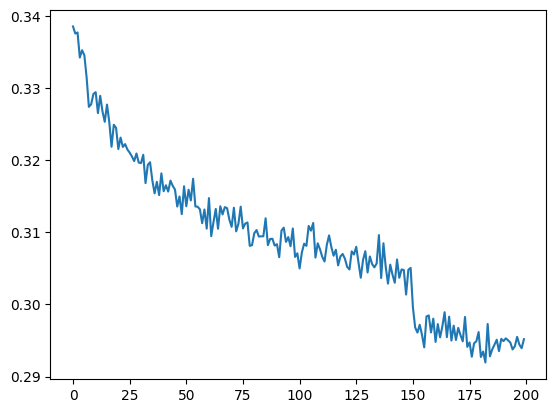

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# put layers in eval mode
for layer in model.layers:
    layer.training = False

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.9384758472442627
val 2.0272438526153564


In [ ]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        logits = model(torch.tensor([context])) 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

rolan
oswen
anz
xylynn
elin
lov
jalyah
laun
hona
jatta
kobaerinson
yuan
kaylus
milora
saclyn
tanii
lla
anthen
jashtyn
rain
